## Load Library

In [ ]:
!pip install keras-tcn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import itertools
from datetime import timedelta, date, datetime
# Tensorflow TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
from tcn import TCN

from scipy import sparse as sp
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.ops.linalg.sparse import sparse as tfsp
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# No item in below list in the dataset, hence, filter 16 items wiht most sales

items =[610407025, 615101406, 622400601, 621937401, 622438401] 
'''
[613250027,610407025,621937401,622400601,620477001,622573101,622010901,
        622080801,620007804,612370067,622491101,622080701,622438401,615101492,
        620477801,615101406]
        ''' 
def item_filter(df, codes=items):
    '''
        Filter the computer codes, return the list codes
    '''
    df = copy.deepcopy(df)

    filter = df['computer_code'].str.contains('U', na = False)
    df = df[~filter]
    df['computer_code'] = df['computer_code'].astype('int')

    df = df[df.computer_code.isin(items)]

    return df


# Unit translating
def store_unit_convert(df):
    # translate store unit into English
    df = df.replace({
        '瓶': 'bottle',
        'ｍＬ': 'ml',
        '錠': 'tablet',
        'ｇ': 'g',
        'カプセル': 'capsule',
        '枚': 'sheet',
        'キット': 'kits',
        'シート': 'sheets',
        '本': 'bottle',
        '包': 'package',
        '個': 'pieces',
        '筒': 'cartridge',
        'ﾌﾞﾘｽﾀｰ': 'blister',
        '缶': 'can',
        '管': 'tube'
    })

    return df

# Setting up for displaying data
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

## Importing data and simple wrangling

In [ ]:
# Importing sales quantity data
sales = pd.read_csv('drive/My Drive/data/sale_update.csv')
sales.quantity = sales.quantity.astype(np.float32)
sales['date'] = pd.to_datetime(sales['date'], format="%d/%m/%Y")

'''
# Discarding all data before 2020-01-01
sales = sales[sales['date'] >= pd.to_datetime('2020-01-01' , format='%Y-%m-%d')]
'''

# Filtering items 
sales = item_filter(sales)

In [ ]:
print(sales.shape)
sales.head()

(17701, 3)


,date,computer_code,quantity
32,2015-06-27,620007804,56.0
36,2015-06-30,621937401,30.0
47,2015-06-30,620007804,70.0
52,2015-01-07,622080801,60.0
66,2015-01-07,622080801,30.0


In [ ]:
# create sales dataframe
sales_df = sales.groupby(['date','computer_code']).agg(['sum']).reindex()
sales_df = sales.pivot_table(index = 'date',
                                      values = 'quantity',
                                      columns = 'computer_code')
sales_df = sales_df.sort_index()
'''                               
sales_df['total'] = sales_df.sum(axis = 1)
'''
sales_df = sales_df.asfreq('D')
sales_df = sales_df.replace(np.nan,0)
sales_df.columns = sales_df.columns.astype(str)

### Lookback 14 days windows

In [ ]:
lookback_window = 14

### Model Defining and Training

In [ ]:
i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()

model.compile('adam','mae')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
tcn_2 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


### Converting Data into Numpy Array, creating list and training 

In [ ]:

temp_df = sales_df.filter(regex=str(613250027))
temp = temp_df.values
x = []
y = []
for i in tqdm(range(lookback_window, len(temp))):
    x.append(temp[i - lookback_window:i])
    y.append(temp[i])

x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

In [ ]:
# Train model 
print('Train...')
model.fit(x, y, epochs=100)
predict = model.predict(x)

### Plot the Result

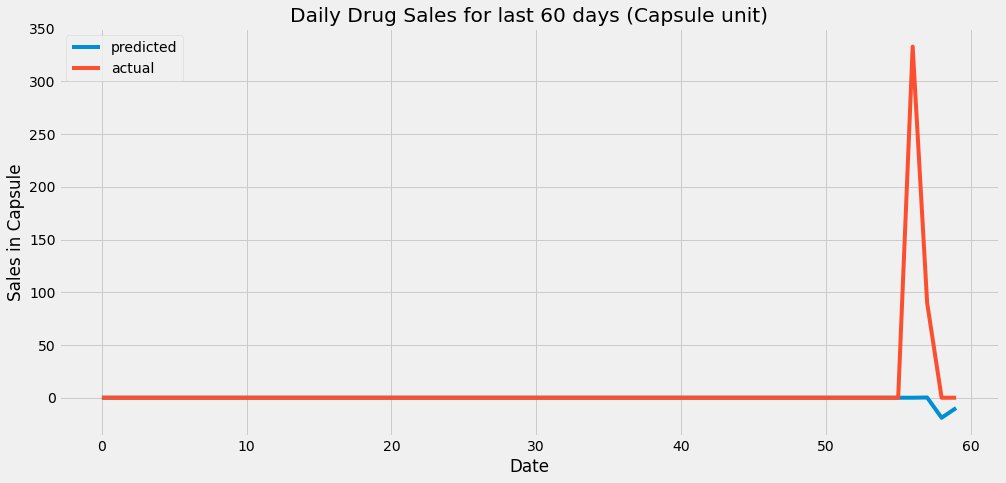

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(predict[-60:])
plt.plot(y[-60:])
plt.title('Daily Drug Sales for last 60 days (Capsule unit)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Date")
plt.ylabel("Sales in Capsule")
plt.show()

### Accuracy measurement

In [18]:
def mean_absolute_percentage_error(actual, pred):
  mask = actual != 0
  return np.fabs((actual-pred)/actual)[mask].mean()

In [ ]:
mean_absolute_percentage_error(y[-60:], predict[-60:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


0.99872607

## Another approach using  GCN

### Defining some functions for GCN


In [4]:
SINGLE  = 1   # Single         (rank(a)=2, rank(b)=2)
MIXED   = 2   # Mixed          (rank(a)=2, rank(b)=3)
iMIXED  = 3   # Inverted mixed (rank(a)=3, rank(b)=2)
BATCH   = 4   # Batch          (rank(a)=3, rank(b)=3)
UNKNOWN = -1  # Unknown


def transpose(a, perm=None, name=None):
    """
    Transposes a according to perm, dealing automatically with sparsity.
    :param a: Tensor or SparseTensor with rank k.
    :param perm: permutation indices of size k.
    :param name: name for the operation.
    :return: Tensor or SparseTensor with rank k.
    """
    if K.is_sparse(a):
        transpose_op = tf.sparse.transpose
    else:
        transpose_op = tf.transpose

    if perm is None:
        perm = (1, 0)  # Make explicit so that shape will always be preserved
    return transpose_op(a, perm=perm, name=name)


def reshape(a, shape=None, name=None):
    """
    Reshapes a according to shape, dealing automatically with sparsity.
    :param a: Tensor or SparseTensor.
    :param shape: new shape.
    :param name: name for the operation.
    :return: Tensor or SparseTensor.
    """
    if K.is_sparse(a):
        reshape_op = tf.sparse.reshape
    else:
        reshape_op = tf.reshape

    return reshape_op(a, shape=shape, name=name)


def autodetect_mode(a, b):
    """
    Return a code identifying the mode of operation (single, mixed, inverted mixed and
    batch), given a and b. See `ops.modes` for meaning of codes.
    :param a: Tensor or SparseTensor.
    :param b: Tensor or SparseTensor.
    :return: mode of operation as an integer code.
    """
    a_dim = K.ndim(a)
    b_dim = K.ndim(b)
    if b_dim == 2:
        if a_dim == 2:
            return SINGLE
        elif a_dim == 3:
            return iMIXED
    elif b_dim == 3:
        if a_dim == 2:
            return MIXED
        elif a_dim == 3:
            return BATCH
    return UNKNOWN


def filter_dot(fltr, features):
    """
    Wrapper for matmul_A_B, specifically used to compute the matrix multiplication
    between a graph filter and node features.
    :param fltr:
    :param features: the node features (N x F in single mode, batch x N x F in
    mixed and batch mode).
    :return: the filtered features.
    """
    mode = autodetect_mode(fltr, features)
    if mode == SINGLE or mode == BATCH:
        return dotted(fltr, features)
    else:
        # Mixed mode
        return mixed_mode_dot(fltr, features)


def dotted(a, b, transpose_a=False, transpose_b=False):
    """
    Dot product between a and b along innermost dimensions, for a and b with
    same rank. Supports both dense and sparse multiplication (including
    sparse-sparse).
    :param a: Tensor or SparseTensor with rank 2 or 3.
    :param b: Tensor or SparseTensor with same rank as a.
    :param transpose_a: bool, transpose innermost two dimensions of a.
    :param transpose_b: bool, transpose innermost two dimensions of b.
    :return: Tensor or SparseTensor with rank 2 or 3.
    """
    a_is_sparse_tensor = isinstance(a, tf.SparseTensor)
    b_is_sparse_tensor = isinstance(b, tf.SparseTensor)
    if a_is_sparse_tensor:
        a = tfsp.CSRSparseMatrix(a)
    if b_is_sparse_tensor:
        b = tfsp.CSRSparseMatrix(b)
    out = tf.linalg.matmul(a, b, transpose_a=transpose_a, transpose_b=transpose_b)
    if hasattr(out, 'to_sparse_tensor'):
        return out.to_sparse_tensor()

    return out


def mixed_mode_dot(a, b):
    """
    Computes the equivalent of `tf.einsum('ij,bjk->bik', a, b)`, but
    works for both dense and sparse input filters.
    :param a: rank 2 Tensor or SparseTensor.
    :param b: rank 3 Tensor or SparseTensor.
    :return: rank 3 Tensor or SparseTensor.
    """
    s_0_, s_1_, s_2_ = K.int_shape(b)
    B_T = transpose(b, (1, 2, 0))
    B_T = reshape(B_T, (s_1_, -1))
    output = dotted(a, B_T)
    output = reshape(output, (s_1_, s_2_, -1))
    output = transpose(output, (2, 0, 1))

    return output


def degree_power(A, k):
    r"""
    Computes \(\D^{k}\) from the given adjacency matrix. Useful for computing
    normalised Laplacian.
    :param A: rank 2 array or sparse matrix.
    :param k: exponent to which elevate the degree matrix.
    :return: if A is a dense array, a dense array; if A is sparse, a sparse
    matrix in DIA format.
    """
    degrees = np.power(np.array(A.sum(1)), k).flatten()
    degrees[np.isinf(degrees)] = 0.
    if sp.issparse(A):
        D = sp.diags(degrees)
    else:
        D = np.diag(degrees)
    return D


def normalized_adjacency(A, symmetric=True):
    r"""
    Normalizes the given adjacency matrix using the degree matrix as either
    \(\D^{-1}\A\) or \(\D^{-1/2}\A\D^{-1/2}\) (symmetric normalization).
    :param A: rank 2 array or sparse matrix;
    :param symmetric: boolean, compute symmetric normalization;
    :return: the normalized adjacency matrix.
    """
    if symmetric:
        normalized_D = degree_power(A, -0.5)
        output = normalized_D.dot(A).dot(normalized_D)
    else:
        normalized_D = degree_power(A, -1.)
        output = normalized_D.dot(A)
    return output


def localpooling_filter(A, symmetric=True):
    r"""
    Computes the graph filter described in
    [Kipf & Welling (2017)](https://arxiv.org/abs/1609.02907).
    :param A: array or sparse matrix with rank 2 or 3;
    :param symmetric: boolean, whether to normalize the matrix as
    \(\D^{-\frac{1}{2}}\A\D^{-\frac{1}{2}}\) or as \(\D^{-1}\A\);
    :return: array or sparse matrix with rank 2 or 3, same as A;
    """
    fltr = A.copy()
    if sp.issparse(A):
        I = sp.eye(A.shape[-1], dtype=A.dtype)
    else:
        I = np.eye(A.shape[-1], dtype=A.dtype)
    if A.ndim == 3:
        for i in range(A.shape[0]):
            A_tilde = A[i] + I
            fltr[i] = normalized_adjacency(A_tilde, symmetric=symmetric)
    else:
        A_tilde = A + I
        fltr = normalized_adjacency(A_tilde, symmetric=symmetric)

    if sp.issparse(fltr):
        fltr.sort_indices()
    return fltr

###  Defining class GCN

In [6]:
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class GraphConv(Layer):
    r"""
    A graph convolutional layer (GCN) as presented by
    [Kipf & Welling (2016)](https://arxiv.org/abs/1609.02907).
    **Mode**: single, mixed, batch.
    This layer computes:
    $$
        \Z = \hat \D^{-1/2} \hat \A \hat \D^{-1/2} \X \W + \b
    $$
    where \( \hat \A = \A + \I \) is the adjacency matrix with added self-loops
    and \(\hat\D\) is its degree matrix.
    **Input**
    - Node features of shape `([batch], N, F)`;
    - Modified Laplacian of shape `([batch], N, N)`; can be computed with
    `spektral.utils.convolution.localpooling_filter`.
    **Output**
    - Node features with the same shape as the input, but with the last
    dimension changed to `channels`.
    **Arguments**
    - `channels`: number of output channels;
    - `activation`: activation function to use;
    - `use_bias`: whether to add a bias to the linear transformation;
    - `kernel_initializer`: initializer for the kernel matrix;
    - `bias_initializer`: initializer for the bias vector;
    - `kernel_regularizer`: regularization applied to the kernel matrix;
    - `bias_regularizer`: regularization applied to the bias vector;
    - `activity_regularizer`: regularization applied to the output;
    - `kernel_constraint`: constraint applied to the kernel matrix;
    - `bias_constraint`: constraint applied to the bias vector.
    """

    def __init__(self,
                 channels,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):

        super().__init__(activity_regularizer=activity_regularizer, **kwargs)
        self.channels = channels
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(shape=(input_dim, self.channels),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.channels,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        features = inputs[0]
        fltr = inputs[1]

        # Convolution
        output = dotted(features, self.kernel)
        output = filter_dot(fltr, output)

        if self.use_bias:
            output = K.bias_add(output, self.bias)

        if mask is not None:
            output *= mask[0]

        output = self.activation(output)

        return output

    def compute_output_shape(self, input_shape):
        features_shape = input_shape[0]
        output_shape = features_shape[:-1] + (self.channels,)
        return output_shape

    def get_config(self):
        config = {
            'channels': self.channels,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @staticmethod
    def preprocess(A):
        return localpooling_filter(A)

### Applying the model

In [5]:
# Importing sales quantity data
sale = pd.read_csv('drive/My Drive/data/sale_eval.csv')
sale.quantity = sale.quantity.astype(np.float32)
sale['date'] = pd.to_datetime(sale['date'], format="%d/%m/%Y")
sale['unit'] = store_unit_convert(sale['unit'])

# Discarding all data before 2018-01-01
sale = sale[sale['date'] >= pd.to_datetime('2018-01-01' , format='%Y-%m-%d')]

'''
sale = sale.groupby(['date','computer_code']).agg(['sum']).reindex()
sale = sale.pivot_table(index = 'date',
                                      values = 'quantity',
                                      columns = 'computer_code')
sale = sale.sort_index()                               
sale = sale.replace(np.nan,0)
sale.columns = sale.columns.droplevel(0)
sale = sale.asfreq('D')
sale = sale.fillna(0)
'''

# Filtering items 
sale = item_filter(sale)

#### Formatting Data from Long to Wide

In [7]:
unstaked_sale = sale.copy()
unstaked_sale['id'] = sale['computer_code'].astype(str)+'_'+sale['unit'].astype(str)
unstaked_sale.set_index(['id','date'], inplace=True)
unstaked_sale.drop(['computer_code','unit'], axis=1, inplace=True)
unstaked_sale = unstaked_sale.reset_index().pivot_table(values = 'quantity',
                                                       index = 'date',
                                                       columns = 'id')
unstaked_sale = unstaked_sale.asfreq('D')
unstaked_sale = unstaked_sale.replace(np.nan, 0)
# Taking the transpose the get the date as attributes
unstaked_sale = unstaked_sale.T

##### Train Data (Correlation, Features)

In [ ]:
# Batch size
sequence_length = 14


def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df


def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
  
    item_level = all_sequence.reshape((-1, 5, seq_len))
    
    item_corr = np.stack([np.corrcoef(i) for i in item_level], axis=0)
    
    item_features = np.stack([
              item_level.mean(axis=2),
              item_level[:,:,int(sequence_length/2):].mean(axis=2),
              item_level.std(axis=2),
              item_level[:,:,int(sequence_length/2):].std(axis=2),
              skew(item_level, axis=2),
              kurtosis(item_level, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, item_level)
            ], axis=1)
    
    item_level = np.transpose(item_level, (0,2,1))
    item_features = np.transpose(item_features, (0,2,1))
    
    return item_level, item_corr, item_features

# Formatting of the y: [[day1 N items], 
#                       [day2 N items]]
def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 5))

# Plot sample sequence for 5 items in 30 days

sequence = get_timespan(unstaked_sale, date(2021,11,5), 30)
sequence.head(10).T.plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# Train, valid, test separation date

train_date = date(2018, 1, 2)
valid_date = date(2020, 1, 2)
test_date = date(2021, 1, 2)


# Train Feature

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_sale, d, sequence_length)
    y_ = create_label(unstaked_sale, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

In [31]:
x = get_timespan(unstaked_sale, date(2018,1,16), 14).values
  
y = x.reshape((-1, 5, 14))

50.91142857142857

In [32]:
y.mean(axis = 2)

array([[ 0., 51., 35.,  0., 52.]], dtype=float32)

In [29]:
unstaked_sale.head(10)

date,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-13,2018-01-14,2018-01-15,2018-01-16,...,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
610407025_ml,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
615101406_g,42.5,52.5,0.0,95.62,0.0,0.0,0.0,131.25,131.25,47.14,90.0,77.50,0.0,45.0,37.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.00,0.0,450.0
621937401_tablet,30.0,75.0,0.0,38.57,52.5,0.0,40.5,40.00,64.00,40.00,50.0,34.83,0.0,30.0,41.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,47.78,60.0,0.0
622400601_tablet,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0,0.00,151.5,0.0
622438401_tablet,0.0,125.0,0.0,107.50,105.0,0.0,0.0,0.00,90.00,126.00,90.0,0.00,0.0,90.0,90.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.00,0.0,0.0


#### Validation and Test data (Correlation, Features)

In [ ]:
# Valid Feature

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_sale, d, sequence_length)
    y_ = create_label(unstaked_sale, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)



# Test Feature

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), date(2021,12,4))):
    seq_, corr_, feat_ = create_features(unstaked_sale, d, sequence_length)
    y_ = create_label(unstaked_sale, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)


In [11]:
# scale sequence 
# Maximum Absolute Scale for sparse sale data
# Standard Scale for feature data

scaler_seq = MaxAbsScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,1)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,1)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,1)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,1)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,1)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,1)).reshape(X_test_feat.shape)


print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

(323, 14, 5) (323, 5, 5) (323, 5, 7) (323, 5)


In [12]:
# Retrieving Laplacian Normalized matrix from correlation matrix

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

#### Train Model and Visualize MAPE


In [13]:
import os
import random 
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# Defining model with Convolution layer for graph learning and LSTM layer for
def get_model():
    
    set_seed(33)

    opt = Adam(learning_rate = 0.001)

    inp_seq = Input((sequence_length,5))
    inp_lap = Input((5, 5))
    inp_feat = Input((5, X_train_feat.shape[-1]))
    '''
    inp_lap_feat = [inp_feat, inp_lap]
    '''
    x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model(inputs = [inp_seq, inp_lap, inp_feat], outputs =  out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    return model

In [15]:
# Define array storing prediction values

pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

------- item 0 -------
Epoch 1/100
3/3 - 3s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 2/100
3/3 - 0s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 3/100
3/3 - 0s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/100
3/3 - 0s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/100
3/3 - 0s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping
------- item 1 -------
Epoch 1/100
3/3 - 59s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 2/100
3/3 - 0s - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_me

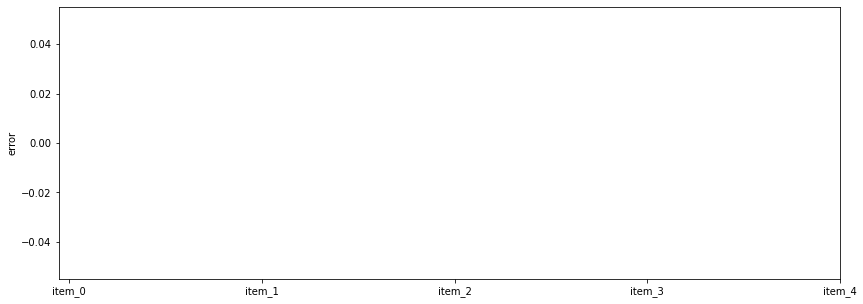

In [19]:
# Training model for all items 

for item in range(5):

    print('-------', 'item', item, '-------')
    
    es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

    model = get_model()
    model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,item], epochs=100, batch_size=256, 
              validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_valid[:,item]), callbacks=[es], verbose=2)

    pred_valid_all[:,item] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,item] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)





# MAPE Test Data

error = {}

for item in range(5):
    
    error[item] = mean_absolute_percentage_error(reverse_test[:,item], pred_test_all[:,item])





# Plot MAPE

plt.figure(figsize=(14,5))
plt.bar(range(5), error.values())
plt.xticks(range(5), ['item_'+str(s) for s in range(5)])
plt.ylabel('error')
np.set_printoptions(False)

#### Plotting Prediction

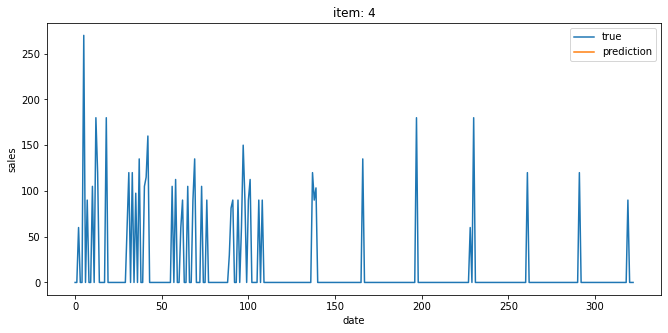

In [24]:
# Plot prediction

def plot_predictions(y_true, y_pred, item):
    
    y_true = y_true.reshape(-1,5)
    y_pred = y_pred.reshape(-1,5)
    
    plt.plot(y_true[:,item], label='true')
    plt.plot(y_pred[:,item], label='prediction')
    plt.title(f"item: {item}"); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')




plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 4)